# Quelle est la meilleure destination pour prendre l’avion de Paris ?

*Bonneau-Chloup Hélène & Brahmi Laura*

Nous souhaitons étudier les prix des billets d’avions au départ de Paris à destination des plus grandes villes du monde (Londres, New-York, Tokyo …). Pour cela, nous allons utiliser les prix des vols disponibles sur le site de Kayak (webscraping), distinguer les compagnies low-cost des compagnies traditionnelles, horaire de départ, escales… Mais aussi la date de départ qui sera le paramètre de notre programme final qui donnerait en sortie : 
- la destination la moins chère de façon absolue
- la destination la moins chère par kilomètre parcouru 

Pour les compagnies “low cost” et les compagnies “traditionnelles” en prenant des allers simples au départ d’un des trois aéroports de Paris selon Kayak : Paris Orly et Paris Charles de Gaulle.

Nous chercherons ainsi à savoir si le prix des billets d’avion dépend de la distance parcourue entre la ville de départ et la ville d’arrivée. Nous représenterons une partie de nos résultats à travers une carte du monde qui illustrera les prix les moins chers au départ de Paris à une date donnée.

Afin de voir les différents déterminants du prix d’un billet d’avion, nous réaliserons également des régressions linéaires du prix en fonction de la distance, des horaires, des escales, des bagages, du type de la compagnie : low-cost ou traditionnelle, des émissions de CO2… (informations disponibles sur le site de Kayak)


## Table des matières
1. [Création de notre base de données](#paragraphe1)
    1. [Scraper Kayak](#subparagraphe11)
      1. [Scraping avec BeautifulSoup](#subsubparagraphe111)
      2. [Scraping avec Sélénium](#subsubparagraphe112)
      3. [Utiliser un API](#subsubparagraphe113)
    2. [Récupération des autres jeux de données :](#subparagraphe12)
      1. [Distance 1ère méthode : scrapping avec Selenium](#subsubparagraphe121)
      2. [Distance 2ème méthode : calcul avec les coordonnées géographiques](#subsubparagraphe122)
2. [Statistiques descriptives](#paragraphe2)
  1. [Prix des vols en fonction de la destination (à date donnée : du 01/02 au 01/03)](#subparagraphe21)
  2. [Prix des vols en fonction de la date (à destination donnée : Londres)](#subparagraphe22)
3. [Modélisation](#paragraphe3)
  1. [Corrélation entre prix et distance : régressions linéaires](#subparagraphe31)
  2. [Kmeans et cluster] (#subparagraphe32)
  3. [ACP](#subparagraphe33)
3. [Visualisation](#paragraphe4)
4. [Conclusion](#paragraphe5)



## Création de notre base de données <a name = "paragraphe1"></a>

Pour notre projet nous avons besoin de différents jeux de données : 
- une liste des aéroports les plus importants du monde
- la distance entre Paris et ces aéroports
- une liste des compagnies aériennes "low cost" et "traditionnelles"
- une liste de dates intéressantes (fêtes, jours fériés, vacances...) pour prendre en compte ces périodes lors de notre analyse des prix des vols
- des données provenant de Kayak : pour chaque vol, obtenir son pix, sa companie aérienne, l'horaire du vol, le nombre de bagages autorisés, le nombre d'escales, les émissions de $CO_2$ de ce vol...


### Scraper Kayak <a name = "subparagraphe11"></a>



On veut récupérer les données de cette page :

In [ ]:
url = 'https://www.kayak.fr/flights/PAR-MAD/2022-02-01?sort=price_a'

Cette page présente les vols à départ de Paris et à destination de Madrid le $1^{er}$ février 2022 pour un aller simple pour une personne adulte. C'est ce genre de vols qu'on retient à priori :    
- un aller-simple
- pour une personne adulte 
- à départ de Paris 
- à destination variable (mais pour commencer le scraping, on fixe la destination à Madrid)
- à date variable (mais pour commencer le sraping, on fixe la date au $1^{er}$ février)

Nous avons rencontré des problèmes lorsque nous avons voulu récupérer des données de Kayak, avec BeautifulSoup, puis avec Sélénium. Nous n'avons pas réussi à trouver une classe qui nous intéresse (*'section duration allow-multi-modal-icons'*), quelque soit la technique de scraping utilisée. Cette classe est utilisée comme exemple pour montrer que nous n'avons pas réussi à avoir accès aux données de Kayak de cette façon là. Elle renvoie aux durées des vols.

Si on ouvre la page et qu'on regarde le code source, on trouve que *'section duration allow-multi-modal-icons'* est un nom de classe qui mène directement aux temps de trajet. Le problème est que nous n'arrivons pas à retrouver cette classe avec BeautifulSoup ou Sélénium.

Kayak fait même en sorte d'être difficile à scrapper : le Xpath du prix d'un billet varie par exemple à chaque connexion sur le site, pour éviter de webscrapper.

#### Scraping avec BeautifulSoup <a name = "subsubparagraphe111"></a>

In [ ]:
!pip install lxml

In [ ]:
import urllib
import bs4
from urllib import request

In [ ]:
req = urllib.request.Request(url,headers={'User-Agent':'Mozilla/5.0'})
html = urllib.request.urlopen(req).read()
page = bs4.BeautifulSoup(html, "lxml")

In [ ]:
page.findAll('div',{'class':"section duration allow-multi-modal-icons"})


[]

In [ ]:
elem = page.select(".section duration allow-multi-modal-icons")
print(elem)

[]


Les listes renvoyées sont toujours vides, alors que ce nom de classe existe bien. En allant voir le code source de la page et en recherchant *'section duration allow-multi-modal-icons'*, on trouve plusieurs occurences de cette classe.

#### Scraping avec Sélénium <a name = "subsubparagraphe112"></a>

In [ ]:
!pip install selenium

In [ ]:
!pip install webdriver-manager

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.7
    Uninstalling urllib3-1.26.7:
      Successfully uninstalled urllib3-1.26.7




We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

selenium 4.1.0 requires urllib3[secure]~=1.26, but you'll have urllib3 1.25.11 which is incompatible.


In [ ]:
import selenium
from selenium import webdriver
#from webdriver_manager.chrome import ChromeDriverManager  
from time import sleep
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome import options
from selenium.webdriver.chrome.options import Options
from selenium.webdriver import ChromeOptions
from selenium.common.exceptions import NoSuchElementException

Les commandes suivantes ne fonctionnent pas sur Google Colab, mais uniquement en local, d'où la mise en commentaire.

In [ ]:
#driver = webdriver.Chrome(ChromeDriverManager().install())

In [ ]:
#driver.get(url)

In [ ]:
#driver.find_elements_by_xpath('//*[@class="section duration allow-multi-modal-icons"]')

La commande ci-dessus renvoie en local cette liste, que nous n'avons pas réussi à exploiter :
```
[<selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="2c68fde4-ad59-4559-9b22-a08f7e6ade1e")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="525b1216-b4b8-4584-8e49-ff45cf58911f")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="476e6118-d09a-410c-b0d2-a77ae80500a0")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="569687cd-39d8-4b13-9ce2-57b771a696e7")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="388dae26-dfbe-4d97-aeff-79daf12231bb")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="c146388e-4593-42a9-8d48-f4467767d74e")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="51a25ea2-bce5-4681-8b33-4d29a43e1d4c")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="1dbe58c2-6a9c-4374-89c0-2011936401e1")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="328e7dcc-272b-47b4-b0de-bcfa01ce4b0d")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="1a81c680-0d13-4707-82b4-e6638c28e912")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="6f0d9f2e-19c1-4d2e-a5a4-061a72cdcfba")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="2910048d-6f7b-41d3-a060-1e36c3a3798b")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="828030ac-e40d-44f8-b572-ae9173930073")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="6fe3182c-61b2-4dc7-a8cb-73a6adcf3b03")>,
 <selenium.webdriver.remote.webelement.WebElement (session="6381230d4c035b7944eb778cfaf0cade", element="db160b2f-aa64-4571-8c66-65e601518262")>]
```

Nous avons tenté de scrapper le site de kayak, les commandes suivantes sont mises en commentaire car elles sont exécutées en local via l'utilisation d'un webdriver.

In [ ]:
#driver = webdriver.Chrome(executable_path="D:/ENSAE/2A 2020 2021/S1/Python data science/chromedriver.exe")
#driver.get(url) #ouverture de la page kayak mais il y a une fenêtre de cookies qui s'ouvre, il faut accepter ou refuser 

Quand on ouvre la page kayak, une fenêtre de cookies apparait. On la ferme pour pouvoir accéder au site.

In [ ]:
#driver.find_element_by_class_name("_ixe").click() 

Avec ce code on arrive à obtenir le prix d'un billet d'avion, mais on n'arrive pas à trouver un même chemin pour tous les vols afin d'obtenir une liste de prix. En effet, le chemin d'un prix change à chaque connexion. Cela semble être une technique de kayak pour éviter le scrapping.

In [ ]:
xp_prices = '//*[@id="T0bh-mb-aE-16e12409bb1-price-text"]' #chemin d'un prix d'un vol
prices = driver.find_elements_by_xpath(xp_prices)
prices_list = [price.text.replace('€','') for price in prices if price.text != '']

<ipython-input-803-31d1f63304fa>:3: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  prices = driver.find_elements_by_xpath(xp_prices)


In [ ]:
prices_list

['28 ']

#### Utiliser une API <a name = "subsubparagraphe113"></a>

Nous avons ensuite pensé à utiliser une API, ce qui nous a permis d'obtenir ce code et d'avoir enfin une base de données de Kayak exploitable.

In [42]:
import requests
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

url = "https://www.kayak.com/s/horizon/exploreapi/destinations?airport=PAR&budget=&depart=20220201&return=20220301&duration=&exactDates=true&flightMaxStops=&stopsFilterActive=false&topRightLat=59.902761633461935&topRightLon=25.09658365167229&bottomLeftLat=26.101275008286677&bottomLeftLon=-6.719822598327707&zoomLevel=4&selectedMarker=&themeCode=&selectedDestination="
req = requests.get(url)
out = req.json()
df_api = pd.json_normalize(out["destinations"])


* On enregistre une version de l'API en local


In [ ]:
#df_local.to_csv('D:/ENSAE/2A 2020 2021/S1/Python data science/dataframe_projet_python_01-02_01-03.csv') 

* Cette version est accessible via Github

In [146]:
url_df = 'https://raw.githubusercontent.com/laurabrmi/Python-pour-le-data-scientist/main/dataframe_projet_python_01-02_01-03.csv'
df = pd.read_csv(url_df,index_col=0)

In [30]:
df.columns

Index(['days', 'originAirportShortName', 'departd', 'returnd', 'airline',
       'airlineCode', 'airlineIcon', 'clickoutUrl', 'flightMaxStops',
       'flightMaxDuration', 'relevancyScore', 'travelRestrictionInfo',
       'flightInfo.price', 'flightInfo.localizedPrice', 'flightInfo.priceUSD',
       'flightInfo.historicalPrice', 'flightInfo.priceless',
       'flightInfo.predicted', 'flightInfo.url', 'airport.latitude',
       'airport.longitude', 'airport.name', 'airport.popularity',
       'airport.shortName', 'city.id', 'city.name', 'city.image',
       'country.code', 'country.name', 'flightInfo.historicPrices'],
      dtype='object')

In [ ]:
df.head(2)

,days,originAirportShortName,departd,returnd,airline,airlineCode,airlineIcon,clickoutUrl,flightMaxStops,flightMaxDuration,relevancyScore,travelRestrictionInfo,flightInfo.price,flightInfo.localizedPrice,flightInfo.priceUSD,flightInfo.historicalPrice,flightInfo.priceless,flightInfo.predicted,flightInfo.url,airport.latitude,airport.longitude,airport.name,airport.popularity,airport.shortName,city.id,city.name,city.image,country.code,country.name,flightInfo.historicPrices
0,28,CDG,20220201,20220301,Multiple Airlines,None,https://content.r9cdn.net/rimg/provider-logos/...,/flights/PAR-NYC/2022-02-01/2022-03-01/,0,9999999,1000,None,322.97,$323,322.97,None,False,True,None,40.75096,-73.98741,None,85682,NYC,15830,New York,None,US,United States,NaN
1,28,LBG,20220201,20220301,Multiple Airlines,None,https://content.r9cdn.net/rimg/provider-logos/...,/flights/PAR-NYC/2022-02-01/2022-03-01/,0,9999999,1000,None,805.06,$805,805.06,None,False,True,None,40.75096,-73.98741,None,85682,NYC,15830,New York,None,US,United States,NaN


Le dataframe obtenu par cette méthode est riche mais nous a obligées à revoir nos objectifs. 

- Nous n'avons pas accès aux compagnies aériennes, la plupart étant regroupées dans le terme **'Multiple Airlines'** (14733 occurences sur 14812). Donc nous ne pourrons pas distinguer selon les compagnies aériennes dans la suite de notre projet. 

In [148]:
df['airline'].value_counts()

Multiple Airlines      14733
Air Austral               19
Air France                 9
Vipper                     6
Air Canada                 5
United Airlines            3
Emirates                   2
Qatar Airways              2
Brussels Airlines          2
American Airlines          2
Finnair                    2
TAP AIR PORTUGAL           2
Turkish Airlines           2
Air Algerie                2
Corsair                    2
Iberia                     2
Kenya Airways              1
Wizz Air                   1
Delta                      1
easyJet                    1
La Compagnie               1
Pegasus Airlines           1
Etihad Airways             1
Icelandair                 1
LATAM Airlines             1
Belavia                    1
British Airways            1
KLM                        1
Air Caraïbes               1
French Bee                 1
Singapore Airlines         1
ASL Airlines France        1
Ryanair                    1
Name: airline, dtype: int64

* Nous nous intéressons donc seulement aux vols de **'Multiple Airlines'**

In [149]:
df=df[df['airline']=='Multiple Airlines']

- Nous n'avons pas accès au nombre de bagages, ni aux horaires des vols, ni au nombre d'escales (de la même façon que pour les compagnies aérinnes, la très grande majorité est sans escale), et ni aux émissions de $CO_2$ du vol.

- Nous avons uniquement accès à des vols aller-retour, donc nous nous baserons sur des voyages d'un mois, en partant tous les $1^{er}$ du mois, de février à novembre inclus.

La colonne **'flightMaxStop'** correspond au nombre d'escale. On remarque que la plupart des vols se font sans escale.

In [33]:
df['flightMaxStops'].value_counts()

0    14710
2       12
1        6
3        5
Name: flightMaxStops, dtype: int64

* Par la suite, nous considérerons tous les vols sans escale.

In [34]:
df=df[df['flightMaxStops']==0]

* On ne garde que les colonnes qui nous intéressent pour la suite.

In [35]:
df=df[['originAirportShortName','departd','returnd','airline',
     'flightInfo.price','flightInfo.localizedPrice','flightInfo.priceUSD','flightMaxStops',
    'airport.latitude','airport.longitude','airport.shortName','city.name','country.name']]
df.head(2) 

,originAirportShortName,departd,returnd,airline,flightInfo.price,flightInfo.localizedPrice,flightInfo.priceUSD,flightMaxStops,airport.latitude,airport.longitude,airport.shortName,city.name,country.name
0,CDG,20220201,20220301,Multiple Airlines,322.97,$323,322.97,0,40.75096,-73.98741,NYC,New York,United States
1,LBG,20220201,20220301,Multiple Airlines,805.06,$805,805.06,0,40.75096,-73.98741,NYC,New York,United States


In [36]:
sum(df['flightInfo.price']==df['flightInfo.priceUSD'])

14710

In [37]:
df.shape

(14710, 13)

* On remarque que **'flightInfo.price'** et **'flightInfo.priceUSD'** sont les mêmes donc on peut garder une seule des deux variables. 

In [ ]:
df=df[['originAirportShortName','departd','returnd',
     'flightInfo.priceUSD',
    'airport.latitude','airport.longitude','airport.shortName','city.name','country.name']]

* On s'intéresse uniquement aux vols au départ des aéroports de Roissy-Charles de Gaulles (CGD) et de Orly (ORY). On laisse de côté les aéroports Paris-Le Bourget (LBG), Paris-Vatry (XCR) et Beauvais (BVA). Un nouveau dataframe **df_paris** est créé.

In [43]:
df_paris=df.loc[df['originAirportShortName'].isin(['CDG','ORY'])]

* Dans la colonne des prix, il y a des prix non renseignés notés en **'999999.0'** on les remplace par des **0**

In [44]:
df_paris.loc[df_paris['flightInfo.priceUSD']== 999999.0] = 0 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


On obtient ainsi une base propre qui contient uniquement les informations utiles.

Pour nous assurer de pouvoir utiliser cette base de données au cas où Kayak bloquerait nos appels, on enregistre cette première base.

(De la même manière que tout à l'heure, cette commande est mise en commentaire car elle ne fonctionne qu'en local.)

In [ ]:
#df_paris.to_csv('dataframe_projet_python_01/02_01/03.csv')

### Récupération des autres jeux de données <a name = subparagraphe12></a>

D'après ce qui a été vu ci-dessus récupérer une liste des compagnies aériennes "lowcost" et "traditionnelles" n'est plus utile.

Pour la liste de dates, nous retenons celle-là : 
* Lundi de Pâques : lundi 18/04/2022
* Fête du travail : dimanche 01/05/2022
* Armistice de 1945 : dimanche 08/05/2022 
* Ascension : jeudi 26/05/2022
* Lundi de Pentecôte : lundi 06/06/2022
* Fête nationale : jeudi 14/07/2022
* Assomption : lundi 15/08/2022
* Toussaint : mardi 01/11/2022
* Armistice de 1918 : vendredi 11/11/2022






Ainsi que la date des vacances scolaires en France :

* hiver : 
    * Zone A = samedi 12/02/2022 au lundi 28/02/2022, Zone B = samedi 05/02/2022 au lundi 21/02/2022, Zone C = samedi 19/02/2022 au lundi 07/03/2022 
* printemps : 
    * Zone A = samedi 16/04/2022 au lundi 02/05/2022, Zone B = samedi 09/04/2022 au lundi 24/04/2022, Zone C = samedi 23/04/2022 au lundi 09/05/2022
* été : 
    * jeudi 07/07/2022 


Au vu de la base de données de Kayak obtenue, nous décidons d'utiliser une liste de villes à la place d'une liste d'aéroports. Nous retenons cette liste de villes :
* Abidjan
* Agadir
* Alger
* Amman
* Amsterdam
* Antalya
* Athènes
* Bangkok
* Barcelone
* Berlin
* Bogota
* Bombay
* Boston
* Budapest
* Buenos-Aires
* Canberra
* Caracas
* Casablanca
* Chicago
* Colombo
* Copenhague
* Dakar
* Delhi
* Djerba
* Djibouti
* Dubaï
* Dublin
* Edimbourg
* Francfort
* Helsinki
* Hong-Kong
* Houston
* Istanbul
* Jakarta
* Johannesburg
* Kuala Lumpur
* Le Caire
* Lisbonne
* Montréal
* New-York
* Los Angeles
* Sydney
* Rome
* Tokyo
* Rio de Janeiro


Pour ce qui est de la distance entre Paris et les villes en questions, nous avons procédé de deux façons différentes.

#### Distance 1ère méthode : scrapping avec Selenium <a name = "subsubparagraphe121"></a>

Les distances sont scrappées à partir d'un site internet. La ville de départ et la ville d'arrivée sont à indiquer et la distance entre ces deux villes nous est communiquée. Nous avons choisi Paris comme ville de départ et une liste est créée avec les distances entre Paris et les villes citées plus haut.

In [ ]:
import re 
import numpy as np
import pandas as pd

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument("private")
options.add_argument("--start-maximized");
options.add_argument("--ignore-certificate-errors");
options.add_argument("--disable-popup-blocking");
options.add_argument("--incognito");
options.add_argument("--headless");


driver = webdriver.Chrome(executable_path="D:/ENSAE/2A 2020 2021/S1/Python data science/chromedriver.exe",options=options)

distances=[]
villes=["Abidjan","Agadir","Alger","Amman","Amsterdam","Antalya","Athènes","Bangkok","Barcelone","Berlin","Bogota","Mumbai",
 "Boston","Budapest","Buenos-Aires","Canberra","Caracas","Casablanca","Chicago","Colombo","Copenhague","Dakar","Delhi",
 "Djerba","Djibouti","Dubaï","Dublin","Edimbourg","Francfort","Helsinki","Hong-Kong","Houston","Istanbul","Jakarta",
 "Johannesburg","Kuala Lumpur","Le Caire","Lisbonne","Montréal","New-York","Los Angeles","Sydney","Rome","Tokyo","Rio de Janeiro"]


driver.get('http://fr.distances-routieres.himmera.com/monde')

for ville in villes : 

    search_bar = driver.find_element_by_id("fr")
    search_bar=driver.find_element_by_id("fr").clear()
    search_bar = driver.find_element_by_id("fr")
    search_bar.send_keys("Paris")
    
    search_bar_bis = driver.find_element_by_id("to")
    search_bar=driver.find_element_by_id("to").clear()
    search_bar = driver.find_element_by_id("to")
    search_bar_bis.send_keys(ville+Keys.ENTER)


    element = driver.find_element_by_class_name("btq").click()
    distance = driver.find_element_by_class_name("t_mi").text
    distance=re.sub('KM','',distance)
    distance=re.sub(' ','',distance)
    distance=int(distance)
    distances.append(distance)
    
    
    driver.get('http://fr.distances-routieres.himmera.com/monde')

    
print(distances)

<ipython-input-124-47b99da7bbe3>:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path="D:/ENSAE/2A 2020 2021/S1/Python data science/chromedriver.exe",options=options)
<ipython-input-124-47b99da7bbe3>:23: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_bar = driver.find_element_by_id("fr")
<ipython-input-124-47b99da7bbe3>:24: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_bar=driver.find_element_by_id("fr").clear()
<ipython-input-124-47b99da7bbe3>:25: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_bar = driver.find_element_by_id("fr")
<ipython-input-124-47b99da7bbe3>:28: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  search_bar_bis = driver.find_element_by_id("to")
<ipython-input-

[4878, 2288, 1347, 3368, 430, 2645, 2096, 9447, 831, 878, 8634, 0, 5533, 1244, 11053, 16924, 7621, 1889, 6653, 8518, 1027, 4198, 6574, 1815, 5535, 5247, 781, 874, 478, 1909, 9619, 8088, 2256, 11589, 8731, 10427, 3211, 1455, 5507, 5839, 9088, 16965, 1106, 9715, 9171]


* On transforme la liste obtenue précédement en un dataframe 

In [ ]:
list_dist=np.array([villes,distances]).T
df_dist=pd.DataFrame(list_dist)
df_dist.columns=['Ville','Distance à Paris (km)']
df_dist

,Ville,Distance à Paris (km)
0,Abidjan,4878
1,Agadir,2288
2,Alger,1347
3,Amman,3368
4,Amsterdam,430
5,Antalya,2645
6,Athènes,2096
7,Bangkok,9447
8,Barcelone,831
9,Berlin,878


#### Distance 2ème méthode : calcul avec les coordonnées géographiques <a name = "subsubparagraphe122"></a>

* On crée une fonction qui permet de calculer les distances entre deux villes à partir de leur latitude et longitude

In [40]:
from math import radians

def haversine(row):
    lon1 = 2.3473 
    lat1 = 48.85749
    lon2 = row['airport.longitude']
    lat2 = row['airport.latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = round(6367 * c)
    return km

* On ajoute une colonne distance entre Paris et la ville correspondante

In [54]:
df_paris['distance'] = df.apply(lambda row: haversine(row), axis=1)
df_paris.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,originAirportShortName,departd,returnd,airline,flightInfo.price,flightInfo.localizedPrice,flightInfo.priceUSD,flightMaxStops,airport.latitude,airport.longitude,airport.shortName,city.name,country.name,distance
0,CDG,20220201,20220301,Multiple Airlines,322.97,$323,322.97,0,40.75096,-73.98741,NYC,New York,United States,5829
3,ORY,20220201,20220301,Multiple Airlines,301.28,$301,301.28,0,40.75096,-73.98741,NYC,New York,United States,5829


La deuxième méthode sera privilégiée car le nom des villes dans le data frame sont en anglais. Par exemple il est indiqué "London" et non "Londres", or cela pose un problème avec le site utilisé pour scrapper les distances car il n'accepte que des noms français. 

## Statistiques descriptives <a name = "paragraphe2"></a>

### Prix des vols en fonction de la destination (à date donnée : du 01/02 au 01/03) <a name = "subparagraphe21"></a>

Dans le dataframe, les nom des villes sont en anglais. On crée donc une liste de villes avec des noms en anglais

In [46]:
villes_en=["Agadir","Amsterdam","Antalya","Athens","Bangkok","Barcelona","Berlin","Mumbai",
           "Boston","Budapest","Canberra","Casablanca","Chicago","Colombo","Copenhagen","Oslo","Dubai",
           "New Delhi","Tunis","Djibouti","Dublin","Edinburgh","Helsinki","Hong Kong","Houston","Jakarta",
           "Johannesburg","Kuala Lumpur","Cairo","Lisbon","Montreal","New York","Rome","Tokyo",
           "Lagos",'Port Louis',"Nairobi","Moscow","Hanoi","London", "Rio de Janeiro","Liberia",
           "Guadalajara","Auckland","Concepción", "Izmir","Chicago"]


Certaines grandes villes apparaissent dans plusieurs pays. Par exemple, il y a Rome en Italie et Rome aux Etats-Unis. Ces villes ne seront donc pas prises en compte. Il y a par exemple Buenos Aires (Argentine et Costa Rica), Sydney (Autralie et Canada)

In [47]:
df_paris[df_paris['city.name']=="Rome"]['country.name'].value_counts()

Italy            6
United States    2
Name: country.name, dtype: int64

* Calcul du prix moyen d'un billet

In [55]:
prix_moyen=[]
nb=[]
dist=[]
for ville in villes_en : 
    p=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].astype(int).mean()
    nbr=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].count()
    distance=df_paris[df_paris['city.name']==ville]['distance'].iloc[0]
    dist.append(distance)
    nb.append(nbr)
    prix_moyen.append(round(p))
    

* On crée une liste de pays correspondant avec les villes sélectionnées

In [56]:
pays=[]
for ville in villes_en:
    pays.append(df_paris[df_paris['city.name']==ville]['country.name'].iloc[0])

* Création d'un dataframe avec le prix et les villes 

In [57]:
list_prix=np.array([villes_en,pays,dist,prix_moyen,nb]).T
df_prix=pd.DataFrame(list_prix)
df_prix.columns=['Ville','Pays','Distance à Paris (km)','Prix moyen du vol en $','Nombre de vol']
df_prix['Prix moyen du vol en $']=df_prix['Prix moyen du vol en $'].astype(str).astype(int)
df_prix.sort_values(by=['Prix moyen du vol en $']) #prix triés de façon croissante


,Ville,Pays,Distance à Paris (km),Prix moyen du vol en $,Nombre de vol
9,Budapest,Hungary,1261,42,2
5,Barcelona,Spain,840,49,2
29,Lisbon,Portugal,1447,54,2
6,Berlin,Germany,876,66,2
20,Dublin,Ireland,785,66,2
21,Edinburgh,United Kingdom,878,74,2
14,Copenhagen,Denmark,1026,90,2
1,Amsterdam,Netherlands,420,96,2
3,Athens,Greece,2113,112,2
15,Oslo,Norway,1378,112,4


**Remarque :** Certaines destinations présentes ne sont proposées que via un seul vol. Par exemple, il n'y a qu'un vol pour Amman au départ de Paris. Le calcul du prix moyen pour ces destinations n'a donc pas un très grand sens. 

* On importe un fichier .csv qui contient une liste de pays avec leur continent. Cela permettra d'indiquer dans le dataframe précédent le continent pour chaque pays. 

In [59]:
df_cont=pd.read_csv("https://raw.githubusercontent.com/laurabrmi/Python-pour-le-data-scientist/main/pays_continent.csv") 
df_prix_cont=df_prix.merge(df_cont,on='Pays')
df_prix_cont['Continent'].value_counts()

Europe           13
Asia             11
Africa            9
North America     8
Oceania           2
South America     2
Name: Continent, dtype: int64

Il y a très peu de pays représentés en Océanie, ou en Amériquer du Sud. Les destinations de notre base de données sont principalement situées en Europe, Asie ou Afrique.

* On réalise ensuite des graphiques de statistiques descriptives :




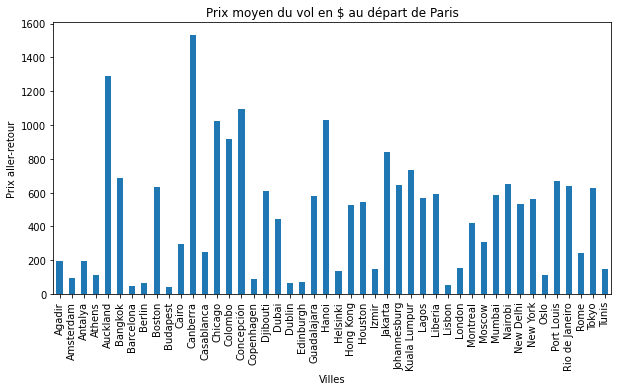

In [60]:
import matplotlib.pyplot as plt 

df1=df_prix.groupby("Ville").sum()['Prix moyen du vol en $']
df1.plot(kind = "bar",xlabel="Villes",ylabel="Prix aller-retour",title="Prix moyen du vol en $ au départ de Paris",figsize=(10, 5))
# remarque : il y a peut être un peu trop de ville, ce n'est pas très lisible 

Les prix les moins chers au départ de Paris sont à destination de villes d'Europe (ex: Budapest, Barlecone, Dublin, Berlin ...). Canberra est la destination dont le prix moyen est le plus cher 1573 \$  au départ de Roissy Charles de Gaulle ou d'Orly. Budapest est la destination la moins chère avec un aller-retour en moyenne qui coûte 49 \$. Ces prix moyens ne reflètent pas nécessairement la réalité car il y a très peu d'effctif pour avoir des résultats significatifs. 

* On affiche les 10 villes les moins chères au départ de Paris 

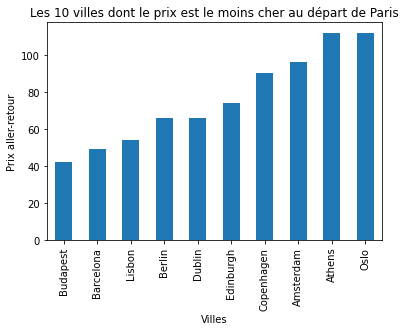

In [61]:
df2=df_prix.groupby("Ville").sum()['Prix moyen du vol en $'].sort_values(ascending=True)
df2.head(10).plot(kind = "bar",xlabel="Villes",ylabel="Prix aller-retour",title="Les 10 villes dont le prix est le moins cher au départ de Paris")

Les 10 destinations les moins chères sont situées en Europe 

* On affiche les 10 villes les plus chères au départ de Paris

<AxesSubplot:title={'center':'Les 10 villes dont le prix est le plus cher au départ de Paris'}, xlabel='Villes', ylabel='Prix aller-retour'>

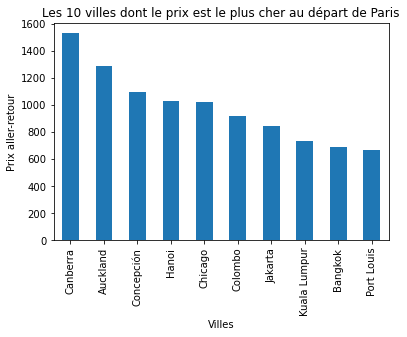

In [ ]:
df3=df_prix.groupby("Ville").sum()['Prix moyen du vol en $'].sort_values(ascending=False)
df3.head(10).plot(kind = "bar",xlabel="Villes",ylabel="Prix aller-retour",title="Les 10 villes dont le prix est le plus cher au départ de Paris")

Les 10 villes les plus chères se situent au niveau de tous les continents sauf l'Europe. Les deux destinations les plus chères (Canberra et Auckland) sont situées en Océanie. 

* On s'intéresse maintenant plus spécifiquement à des villes aux Etats-Unis : New York, Los Angeles, Miami et Las Vegas.

In [62]:
villes_usa=["New York","Chicago","Miami","Las Vegas"]

prix_moyen_USA=[]
nb_usa=[]
dist_usa=[]
for ville in villes_usa : 
    p=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].astype(int).mean()
    nbr=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].count()
    distance=df_paris[df_paris['city.name']==ville]['distance'].iloc[0]
    nb_usa.append(nbr)
    dist_usa.append(distance)
    prix_moyen_USA.append(round(p))


On crée un dataframe pour les villes américaines

In [63]:
list_prix_usa=np.array([villes_usa,prix_moyen_USA,dist_usa,nb_usa]).T
df_prix_usa=pd.DataFrame(list_prix_usa)
df_prix_usa.columns=['Ville','Prix moyen du vol en $','Distance à Paris (km)','Nombre de vol']
df_prix_usa['Prix moyen du vol en $']=df_prix_usa['Prix moyen du vol en $'].astype(str).astype(int)
df_prix_usa.sort_values(by=['Prix moyen du vol en $'])

,Ville,Prix moyen du vol en $,Distance à Paris (km),Nombre de vol
2,Miami,373,7356,2
1,Chicago,511,6656,8
0,New York,562,5829,4
3,Las Vegas,645,8732,4


New-York est la ville américaine la plus desservie au départ de Paris. 6 vols sont proposés pendant la période étudiée.

<AxesSubplot:title={'center':'Prix moyen du vol en $ au départ de Paris'}, xlabel='Villes américaines', ylabel='Prix aller-retour'>

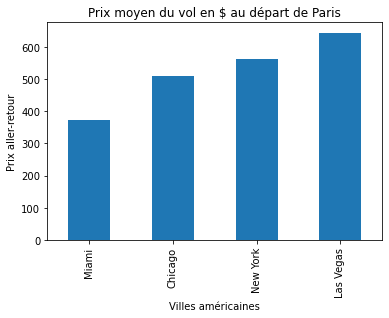

In [ ]:
df1=df_prix_usa.groupby("Ville").sum()['Prix moyen du vol en $'].sort_values()
df1.plot(kind = "bar",xlabel="Villes américaines",ylabel="Prix aller-retour",title="Prix moyen du vol en $ au départ de Paris")

Miami est la ville dont le prix moyen aller-retour de Paris est le moins cher (373 $), mais ce n'est pas la ville qui est la plus proche de Paris. Elle se trouve à 7356 km alors que New-York est à 5829 km. On peut se demander s'il existe une corrélation entre le prix et la distance. On étudiera cette corrélation dans la partie modélisation de ce projet.


### Prix des vols en fonction de la date (à destination donnée : Londres) <a name = "subparagraphe22"></a>

Nous allons maintenant nous intéresser au prix des vols par rapport aux dates du voyage.


In [64]:
df_paris.value_counts("city.name") 

city.name
London         16
Stockholm      10
Moscow         10
Columbus        8
Georgetown      8
               ..
Parkersburg     2
Parintins       2
Parikia         2
Pardubice       2
A Coruña        2
Length: 2748, dtype: int64

On remarque que Londres est la ville la plus désservie, c'est donc celle-ci qu'on choisit pour étudier le prix des vols selon la période de l'année.

On crée une fonction qui renvoie la base de données réduite à Londres pour une date de départ et une date de retour données.

In [ ]:
def df_lon(dat1,dat2):
  pd.set_option('display.max_columns', 500)
  url = "https://www.kayak.com/s/horizon/exploreapi/destinations?airport=PAR&budget=&depart="+dat1+"&return="+dat2+"&duration=&exactDates=true&flightMaxStops=&stopsFilterActive=false&topRightLat=59.902761633461935&topRightLon=25.09658365167229&bottomLeftLat=26.101275008286677&bottomLeftLon=-6.719822598327707&zoomLevel=4&selectedMarker=&themeCode=&selectedDestination="
  req = requests.get(url)
  out = req.json()
  dfl = pd.json_normalize(out["destinations"])
  dfl = dfl.loc[dfl['originAirportShortName'].isin(['CDG','ORY'])] #on se limite à CDG et ORY
  dfl = dfl[dfl["city.name"]=="London"]
  dfl.loc[dfl['flightInfo.priceUSD']== 999999.0] = 0 #certains prix sont normalisés à 999999.0 -> on les ramène à 0
  dfl = dfl[dfl['airline']=='Multiple Airlines']
  dfl = dfl[dfl['flightMaxStops']==0]
  return dfl


On crée une liste de dates qui correspondent aux mois de l'année.

In [ ]:
dates=["20220201","20220301","20220401","20220501","20220601","20220701","20220801","20220901","20221001","20221101","20221201"]

On crée aussi une liste de dates "utiles" qui correspondent aux jours fériés et au début des vacances scolaires.

In [ ]:
dates_utiles=["20220418","20220501","20220508","20220526","20220606","20220714","20220815","20221101","20221111","20220212","20220205","20220219","20220409","20220416","20220423","20220707"]

On crée une liste de prix moyens en utilisant la liste de dates et la fonction df_lon.

In [ ]:
lon_prix=[]
for i in range(len(dates)-1):
  dfd = df_lon(dates[i],dates[i+1])
  prix = dfd["flightInfo.priceUSD"].mean()
  lon_prix.append(prix)

On écrit la fonctionne df_lon_une_date qui à une date donnée renvoie le prix d'un voyage de un mois à destination de Londres qui commence à cette date.

In [ ]:
def df_lon_une_date(date):
  pd.set_option('display.max_columns', 500)
  datebis = int(date)+100
  datebis=str(datebis)
  url = "https://www.kayak.com/s/horizon/exploreapi/destinations?airport=PAR&budget=&depart="+date+"&return="+datebis+"&duration=&exactDates=true&flightMaxStops=&stopsFilterActive=false&topRightLat=59.902761633461935&topRightLon=25.09658365167229&bottomLeftLat=26.101275008286677&bottomLeftLon=-6.719822598327707&zoomLevel=4&selectedMarker=&themeCode=&selectedDestination="
  req = requests.get(url)
  out = req.json()
  dfl = pd.json_normalize(out["destinations"])
  dfl = dfl.loc[dfl['originAirportShortName'].isin(['CDG','ORY'])] #on se limite à CDG et ORY
  dfl = dfl[dfl["city.name"]=="London"]
  dfl.loc[dfl['flightInfo.priceUSD']== 999999.0] = 0 #certains prix sont normalisés à 999999.0 -> on les ramène à 0
  dfl = dfl[dfl['airline']=='Multiple Airlines']
  dfl = dfl[dfl['flightMaxStops']==0]
  return dfl

On récupère les prix des voyages pour les dates "utiles" grâce à la foncton précédente.

In [ ]:
lon_prix_utiles=[]
for i in range(len(dates_utiles)):
  dfd = df_lon_une_date(dates_utiles[i])
  prix = dfd["flightInfo.priceUSD"].mean()
  lon_prix_utiles.append(prix)

On crée une liste des mois correspondant à la liste de dates précédente.

In [ ]:
mois=["février","mars","avril","mai","juin","jullet","août","septembre","octobre","novembre"]

Et une légende pour la liste de dates "utiles".

In [ ]:
evenements = ["Lundi de Pâques","Fête du travail","Armistice de 1945","Ascension","Lundi de Pentecôte","Fête nationale",
                "Assomption","Toussaint","Armistice de 1918 ","Début des vacances de février zone A","Début des vacances de février zone B",
                "Début des vacances de février zone C","Début des vacances de Pâques zone A","Début des vacances de Pâques zone B","Début des vacances de Pâques zone C",
                "Début des grandes vacances"]

On construit un dataframe avec les dates, les prix et le mois.

In [ ]:
df_prix_london=pd.DataFrame(dates[:10], columns=["dates"])
df_prix_london["prix"]=lon_prix
df_prix_london["mois"]=mois

In [ ]:
df_prix_london_utiles=pd.DataFrame(dates_utiles, columns=["dates"])
df_prix_london_utiles["prix"]=lon_prix_utiles
df_prix_london_utiles["evenements"]=evenements

On affiche les résulats.

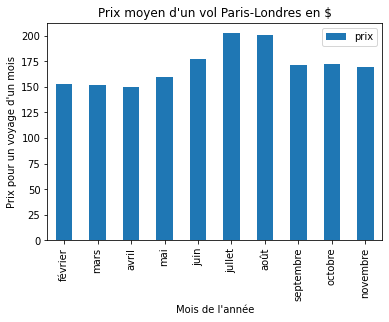

In [ ]:
df_prix_london.plot(x="mois",y="prix",kind = "bar",xlabel="Mois de l'année",ylabel="Prix pour un voyage d'un mois",title="Prix moyen d'un vol Paris-Londres en $")

On voit un pic de prix pendant les vacances d'été (en juillet et en août le prix est le plus élevé). La période creuse semble être en avril et en septembre, lorsque la météo n'est pas forcément bonne et qu'il n'y a pas de vacances.



On affiche aussi les prix des voyages d'un mois commençant aux dates "utiles".

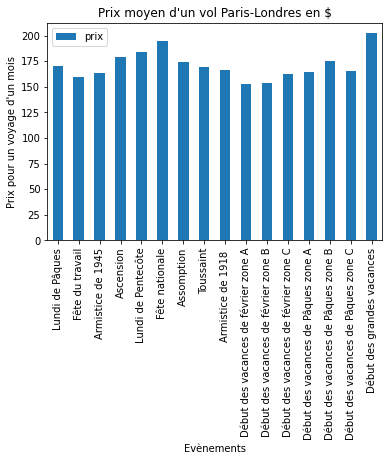

In [ ]:
df_prix_london_utiles.plot(x="evenements",y="prix",kind = "bar",xlabel="Evènements",ylabel="Prix pour un voyage d'un mois",title="Prix moyen d'un vol Paris-Londres en $")

On remarque les prix sont un peu plus élevés pendant les jours fériés. En revanche ils ne le sont pas particulièrement pendant le premier jour des vacances de février (ce qui peut se comprendre car Londres n'est pas la destination privilégiée à cette période).

## Modélisation <a name = "paragraphe3"></a>

### Corrélation entre prix et distance <a name = "subparagraphe31"></a>

In [65]:
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


 **Régression linéaire**
  
On effectue une régression linéaire avec toutes les villes de la base de données

Text(0.5, 1.0, "Prix d'un vol aller-retour au départ de Paris en fonction de la distance de la destination")

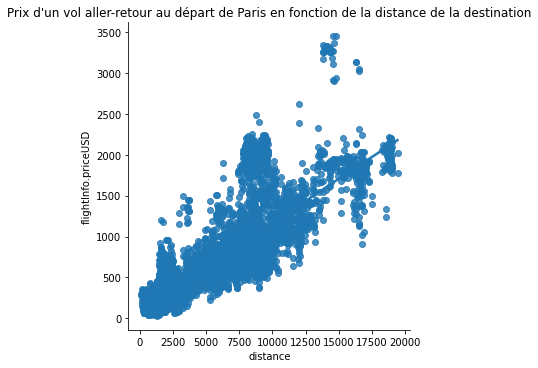

In [135]:
sns.lmplot(x="distance", y="flightInfo.priceUSD", data=df_paris)
ax=plt.gca()
ax.set_title("Prix d'un vol aller-retour au départ de Paris en fonction de la distance de la destination")

On remarque que pour les faibles distances le modèle est assez linéaire, alors que pour les grandes distances les prix sont très dispersés. Il y a une corrélation positive entre le prix et la distance.

* On trace un nuage de points avec les villes qu'on a sélectionnées précédemment (celles de la liste **villes_en**)

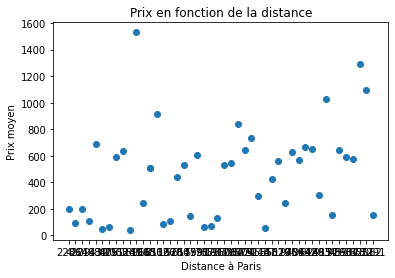

In [142]:
plt.scatter(df_prix['Distance à Paris (km)'],df_prix['Prix moyen du vol en $'])
plt.xlabel('Distance à Paris')
plt.ylabel('Prix moyen')
plt.title('Prix en fonction de la distance')
plt.show()


On regroupe les résultats par continents, cela s'apparente à un clustering.

In [69]:
df_africa=df_prix_cont[df_prix_cont['Continent']=='Africa']
df_europe=df_prix_cont[df_prix_cont['Continent']=='Europe']
df_oceania=df_prix_cont[df_prix_cont['Continent']=='Oceania']
df_asia=df_prix_cont[df_prix_cont['Continent']=='Asia']
df_namerica=df_prix_cont[df_prix_cont['Continent']=='North America']
df_samerica=df_prix_cont[df_prix_cont['Continent']=='South America']


df_africa=df_africa[['Distance à Paris (km)','Prix moyen du vol en $']]
df_europe=df_europe[['Distance à Paris (km)','Prix moyen du vol en $']]
df_oceania=df_oceania[['Distance à Paris (km)','Prix moyen du vol en $']]
df_asia=df_asia[['Distance à Paris (km)','Prix moyen du vol en $']]
df_namerica=df_namerica[['Distance à Paris (km)','Prix moyen du vol en $']]
df_samerica=df_samerica[['Distance à Paris (km)','Prix moyen du vol en $']]


* On réalise un nuage de points en distinguant chaque contient 

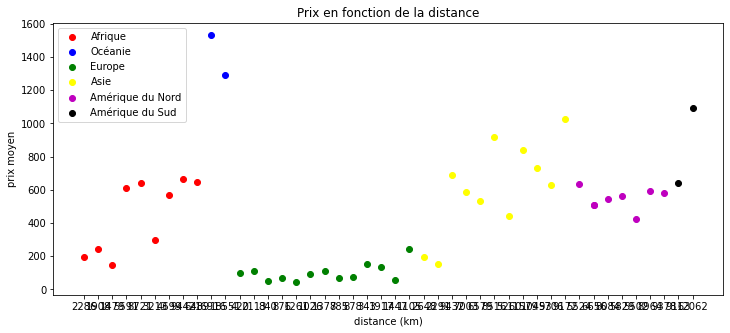

In [83]:
plt.figure(figsize=(12, 5))
plt.scatter(df_africa['Distance à Paris (km)'],df_africa['Prix moyen du vol en $'], c='Red', label='Afrique')
plt.scatter(df_oceania['Distance à Paris (km)'],df_oceania['Prix moyen du vol en $'], c='Blue',label='Océanie')
plt.scatter(df_europe['Distance à Paris (km)'],df_europe['Prix moyen du vol en $'], c='Green',label='Europe')
plt.scatter(df_asia['Distance à Paris (km)'],df_asia['Prix moyen du vol en $'], c='Yellow',label='Asie')
plt.scatter(df_namerica['Distance à Paris (km)'],df_namerica['Prix moyen du vol en $'], c='m',label='Amérique du Nord')
plt.scatter(df_samerica['Distance à Paris (km)'],df_samerica['Prix moyen du vol en $'], c='k',label='Amérique du Sud')

plt.xlabel('distance (km)')
plt.ylabel('prix moyen')
plt.legend()
plt.title('Prix en fonction de la distance')
plt.show()

Deux groupes se distinguent : l'un avec l'Europe, l'Asie, l'Amérique du Nord et l'Amérique du Sud, l'autre avec l'Afrique et l'Océanie. Il serait peut être intéressant de faire deux régressions linéaires différentes entre ces deux groupes. 

* Régression linéaire en distingant les continents

On crée des nouveaux dataframes correspondants aux groupes de continent que l'on souhaite 

In [ ]:
df_afr_oce=df_prix_cont.loc[df_prix_cont['Continent'].isin(['Africa','Oceania'])]
df_autre_contient=df_prix_cont.loc[df_prix_cont['Continent'].isin(['North America','South America','Europe','Asia'])]

#d['Distance à Paris (km)'] était en object, on le transforme en int:
df_afr_oce['Distance à Paris (km)']=df_afr_oce['Distance à Paris (km)'].astype(str).astype(int) 
df_autre_contient['Distance à Paris (km)']=df_autre_contient['Distance à Paris (km)'].astype(str).astype(int)

On trace les régressions linéaires correspondantes

Text(0.5, 1.0, 'Prix en fonction de la distance pour les pays des autres continents')

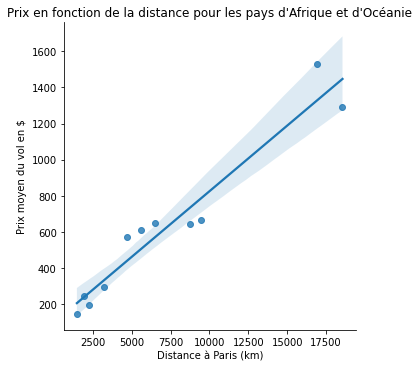

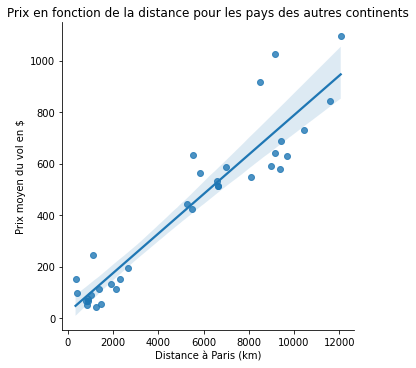

In [150]:
sns.lmplot(x="Distance à Paris (km)", y="Prix moyen du vol en $",data=df_afr_oce) 
ax=plt.gca()
ax.set_title("Prix en fonction de la distance pour les pays d'Afrique et d'Océanie")
sns.lmplot(x="Distance à Paris (km)", y="Prix moyen du vol en $",data=df_autre_contient) 
bx=plt.gca()
bx.set_title("Prix en fonction de la distance pour les pays des autres continents")

**Régression linéaire avec statsmodels**

In [136]:
X = df_paris[["distance"]]
y = df_paris["flightInfo.priceUSD"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                                 OLS Regression Results                                 
Dep. Variable:     flightInfo.priceUSD   R-squared (uncentered):                   0.880
Model:                             OLS   Adj. R-squared (uncentered):              0.880
Method:                  Least Squares   F-statistic:                          4.314e+04
Date:                 Tue, 04 Jan 2022   Prob (F-statistic):                        0.00
Time:                         21:35:23   Log-Likelihood:                         -42709.
No. Observations:                 5884   AIC:                                  8.542e+04
Df Residuals:                     5883   BIC:                                  8.543e+04
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Toutes choses égales par ailleurs, si la distance à Paris augmente de 1km, le prix du billet d'avion augmente de 0,12 \$. Le coefficient de distance est significatif au seuil de 1%. Le $R^{2}$ est assez bon, il est de 0,88.

**Remarque** : Ce modèle est un modèle linéaire (il n'y a pas de constante dans la sortie proposée par statsmodels). Nous regardons maintenant ce que peut donner un modèle affine.

In [137]:
X = df_paris[["distance"]]
y = df_paris["flightInfo.priceUSD"]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     flightInfo.priceUSD   R-squared:                       0.598
Model:                             OLS   Adj. R-squared:                  0.598
Method:                  Least Squares   F-statistic:                     8763.
Date:                 Tue, 04 Jan 2022   Prob (F-statistic):               0.00
Time:                         21:38:11   Log-Likelihood:                -42647.
No. Observations:                 5884   AIC:                         8.530e+04
Df Residuals:                     5882   BIC:                         8.531e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.0728      9.001     11.22

L'ajout de la constante ajuste le coefficent de distance dans la régression linéaire du prix en fonction de la distance.

On réalise une autre régression mais cette fois pour les pays d'Afrique et d'Océanie

In [139]:
X = df_afr_oce[["Distance à Paris (km)"]]
y = df_afr_oce["Prix moyen du vol en $"]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     Prix moyen du vol en $   R-squared:                       0.932
Model:                                OLS   Adj. R-squared:                  0.925
Method:                     Least Squares   F-statistic:                     123.7
Date:                    Tue, 04 Jan 2022   Prob (F-statistic):           1.46e-06
Time:                            21:42:18   Log-Likelihood:                -67.218
No. Observations:                      11   AIC:                             138.4
Df Residuals:                           9   BIC:                             139.2
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


In [140]:
X = df_autre_contient[["Distance à Paris (km)"]]
y = df_autre_contient["Prix moyen du vol en $"]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                              OLS Regression Results                              
Dep. Variable:     Prix moyen du vol en $   R-squared:                       0.886
Model:                                OLS   Adj. R-squared:                  0.882
Method:                     Least Squares   F-statistic:                     248.1
Date:                    Tue, 04 Jan 2022   Prob (F-statistic):           1.24e-16
Time:                            21:42:49   Log-Likelihood:                -206.06
No. Observations:                      34   AIC:                             416.1
Df Residuals:                          32   BIC:                             419.2
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

La regréssion linéaire pour l'Afrique, l'Océanie et celle avec les autres continents sont quasi identiques. Le coeffecient de la distance est du même ordre de grandeur : O,072 pour la première et 0,076 pour la seconde.

#### Kmeans et clustering <a name = "subparagraphe32"></a>

Nous allons réaliser des clusters en fonction des continents. 

On définit un dataframe

In [95]:
df_reg=df_prix_cont.loc[:,["Prix moyen du vol en $","Distance à Paris (km)"]]

Il y a 6 continents donc on part tout d'abord sur l'hypothèse de n=6. Puis, on fixe les labels pour le clustering.

In [110]:
from sklearn.cluster import KMeans #pour kmeans

kmeans = KMeans(n_clusters=6).fit(df_reg) # on regarde par rapport aux 6 continents 
df_reg['label']=kmeans.labels_
df_reg["label"].value_counts()
df_reg.head(2)

,Prix moyen du vol en $,Distance à Paris (km),label
0,198,2286,1
1,246,1908,1


On trace le nuage de point relatif au clustering (pour n=6).

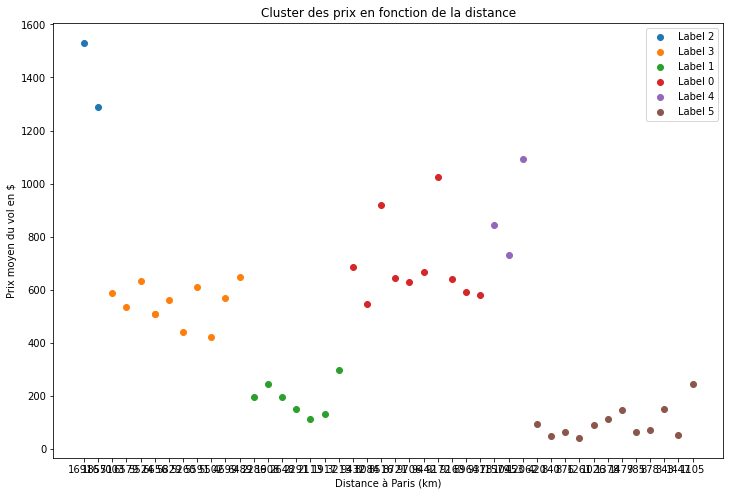

In [111]:
df_label2=df_reg[df_reg['label']==2]
df_label3=df_reg[df_reg['label']==3]
df_label1=df_reg[df_reg['label']==1]
df_label0=df_reg[df_reg['label']==0]
df_label4=df_reg[df_reg['label']==4]
df_label5=df_reg[df_reg['label']==5]


plt.figure(figsize=(12, 8))
plt.scatter(df_label2['Distance à Paris (km)'],df_label2['Prix moyen du vol en $'],label='Label 2')
plt.scatter(df_label3['Distance à Paris (km)'],df_label3['Prix moyen du vol en $'],label='Label 3')
plt.scatter(df_label1['Distance à Paris (km)'],df_label1['Prix moyen du vol en $'],label='Label 1')
plt.scatter(df_label0['Distance à Paris (km)'],df_label0['Prix moyen du vol en $'],label='Label 0')
plt.scatter(df_label4['Distance à Paris (km)'],df_label4['Prix moyen du vol en $'],label='Label 4')
plt.scatter(df_label5['Distance à Paris (km)'],df_label5['Prix moyen du vol en $'],label='Label 5')
plt.legend()
plt.xlabel('Distance à Paris (km)')
plt.ylabel('Prix moyen du vol en $')
plt.title('Cluster des prix en fonction de la distance')
plt.show()

Si on regarde par rapport au prix, on remarque qu'il y a 3 grands groupes. L'un entre 0 et 200€, un autre entre 400€ et 1000€, puis un dernier entre 1200-1600€. On pourrait essayer de faire un cluster avec n=3. 

Nous avons regardé auparavant le prix en fonction de la distance, on peut également regarder la distance en fonction des prix. 

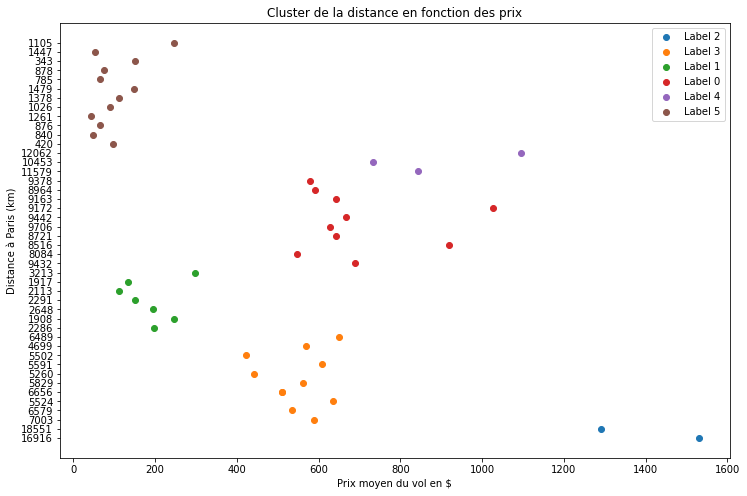

In [112]:
plt.figure(figsize=(12, 8))
plt.scatter(df_label2['Prix moyen du vol en $'],df_label2['Distance à Paris (km)'],label='Label 2')
plt.scatter(df_label3['Prix moyen du vol en $'],df_label3['Distance à Paris (km)'],label='Label 3')
plt.scatter(df_label1['Prix moyen du vol en $'],df_label1['Distance à Paris (km)'],label='Label 1')
plt.scatter(df_label0['Prix moyen du vol en $'],df_label0['Distance à Paris (km)'],label='Label 0')
plt.scatter(df_label4['Prix moyen du vol en $'],df_label4['Distance à Paris (km)'],label='Label 4')
plt.scatter(df_label5['Prix moyen du vol en $'],df_label5['Distance à Paris (km)'],label='Label 5')
plt.legend()
plt.xlabel('Prix moyen du vol en $')
plt.ylabel('Distance à Paris (km)')
plt.title('Cluster de la distance en fonction des prix')
plt.show()

On réalise un cluster avec n=3.

In [113]:
kmeans = KMeans(n_clusters=3).fit(df_reg) # on regarde par rapport aux 6 continents 
df_reg['label']=kmeans.labels_
df_reg["label"].value_counts()


0    23
1    20
2     2
Name: label, dtype: int64

On trace le nuage de point relatif au clustering (pour n=3).

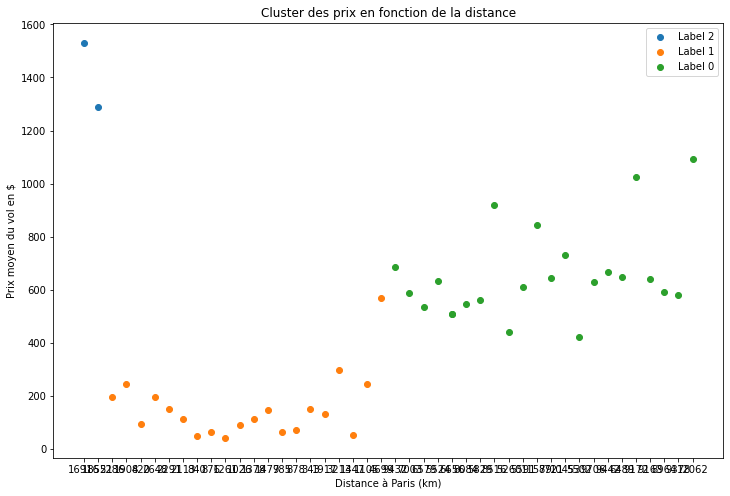

In [114]:
df_label2=df_reg[df_reg['label']==2]
df_label1=df_reg[df_reg['label']==1]
df_label0=df_reg[df_reg['label']==0]


plt.figure(figsize=(12, 8))
plt.scatter(df_label2['Distance à Paris (km)'],df_label2['Prix moyen du vol en $'],label='Label 2')
plt.scatter(df_label1['Distance à Paris (km)'],df_label1['Prix moyen du vol en $'],label='Label 1')
plt.scatter(df_label0['Distance à Paris (km)'],df_label0['Prix moyen du vol en $'],label='Label 0')

plt.legend()
plt.xlabel('Distance à Paris (km)')
plt.ylabel('Prix moyen du vol en $')
plt.title('Cluster des prix en fonction de la distance')
plt.show()

Nous distinguons 3 groupes de destinations différentes (à commenter plus peut être)

### ACP <a name = "subparagraphe33"></a>

Nous avions l'idée de réaliser une ACP, mais l'ACP n'est pas pertinente dans notre modèle puisque nous n'avons que deux paramètres : le prix et la distance. Pour utiliser l'ACP, il faudrait plus de paramètres.

Ci-dessous se trouve quelques pistes de recherches que nous avonc effectuées.

In [ ]:
df_acp=df_paris[["distance","flightInfo.priceUSD","city.name"]]
df_acp.set_index('city.name')

,distance,flightInfo.priceUSD
city.name,,
New York,5829,322.97
New York,5829,301.28
London,343,68.95
London,343,67.74
Miami,7356,381.85
...,...,...
Shiyan,8529,2103.01
Weifang,8643,2146.07
Nantong,9154,2137.48


In [ ]:
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

On calcule le coeffecient de corrélation entre la distance et le prix d'un billet d'avion.

In [ ]:
df_acp=(df_paris[["distance","flightInfo.priceUSD"]]).values

coeff_corr, pvalue=pearsonr(df_acp[:,0],df_acp[:,1])
print(coeff_corr, pvalue) #il y a une corrélation entre le prix et la distance 

0.7735300900805997 0.0


On trace le nuage de point correspondant

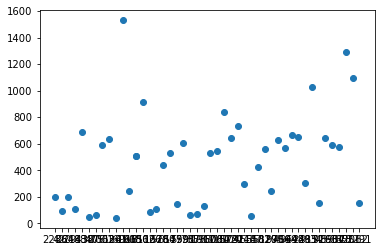

In [ ]:
plt.scatter(df_prix['Distance à Paris (km)'],df_prix['Prix moyen du vol en $'])


On calcule les coefficients de l'ACP

In [ ]:
model_acp=PCA()
coeff_acp=model_acp.fit_transform(df_acp)

comp1=coeff_acp[:,0]
comp2=coeff_acp[:,1]

coeff_corr, pvalue=pearsonr(comp1,comp2)
print(coeff_corr, pvalue) 

1.3877787807814457e-17 1.0000000000058695


On remarque qu'il n'y a plus de corrélation entre les composantes principales. Le coefficient de corrélation est égale à 1.3877787807814457e-17, ce qui est très faible.

On trace le nuage de point correspondant.

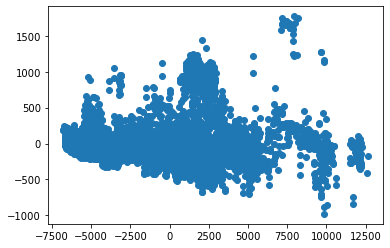

In [ ]:
plt.scatter(comp1,comp2)
plt.show()

## Visualisation <a name = "paragraphe4"></a>

On utilise une partie de ce qui a déjà été fait dans la partie de statistqiues descriptives sur la destination du vol.

In [ ]:
df_paris #on reprend le dataframe qui réduit Paris aux aéroports Charles de Gaulle (CDG) et Orly (ORY)

,originAirportShortName,departd,returnd,airline,flightInfo.priceUSD,flightMaxStops,airport.latitude,airport.longitude,airport.shortName,city.name,country.name,distance
0,CDG,20220201,20220301,Multiple Airlines,322.97,0,40.750960,-73.987410,NYC,New York,United States,5829
3,ORY,20220201,20220301,Multiple Airlines,301.28,0,40.750960,-73.987410,NYC,New York,United States,5829
6,CDG,20220201,20220301,Multiple Airlines,68.95,0,51.507350,-0.127660,LON,London,United Kingdom,343
9,ORY,20220201,20220301,Multiple Airlines,67.74,0,51.507350,-0.127660,LON,London,United Kingdom,343
11,CDG,20220201,20220301,Multiple Airlines,381.85,0,25.796521,-80.286617,MIA,Miami,United States,7356
...,...,...,...,...,...,...,...,...,...,...,...,...
14577,ORY,20220201,20220301,Multiple Airlines,2103.01,0,32.591800,110.907670,WDS,Shiyan,China,8529
14578,ORY,20220201,20220301,Multiple Airlines,2146.07,0,36.646700,119.119000,WEF,Weifang,China,8643
14579,ORY,20220201,20220301,Multiple Airlines,2137.48,0,32.070800,120.976000,NTG,Nantong,China,9154
14580,ORY,20220201,20220301,Multiple Airlines,2184.50,0,46.843400,130.465000,JMU,Jiamusi,China,8250


Pour chaque ville de la liste **'villes_en'**, on calcule le prix moyen d'un vol.

In [ ]:
prix_m=[]
for ville in villes_en : 
    p=df_paris[df_paris['city.name']==ville]['flightInfo.priceUSD'].astype(int).mean()
    prix_m.append(round(p))

On récupère également la lattitude et la longitude des villes pour pouvoir tracer une carte du monde.

In [ ]:
latitude=[]
for ville in villes_en:
    latitude.append(df_paris[df_paris['city.name']==ville]['airport.latitude'].iloc[0])
    longitude=[]
for ville in villes_en:
    longitude.append(df_paris[df_paris['city.name']==ville]['airport.longitude'].iloc[0])

On crée un dataframe avec ces données.

In [ ]:
liste_prix=np.array([villes_en,prix_m,latitude,longitude]).T
df_prix=pd.DataFrame(liste_prix)
df_prix.columns=['Ville','Prix moyen du vol en $','Latitude','Longitude']

In [ ]:
df_prix.head()

,Ville,Prix moyen du vol en $,Latitude,Longitude
0,Agadir,198,30.325,-9.41307
1,Amsterdam,96,52.30736127010797,4.767146455078091
2,Antalya,196,36.89873,30.80046
3,Athens,112,37.93636,23.944470000000003
4,Bangkok,688,13.913579750656696,100.60606335449222


On a donc créé un dataframa qui contient le nom des villes, les prix moyen d'un vol en \$, la latitude, la longitude et le nombre de vols.

On spécifie le type des colonnes pour pouvoir faire des calculs sur ces valeurs.

In [ ]:
df_prix['Latitude']=df_prix['Latitude'].astype(float)
df_prix['Longitude']=df_prix['Longitude'].astype(float)
df_prix['Prix moyen du vol en $']=df_prix['Prix moyen du vol en $'].astype(int)

On trie le dataframe dans l'ordre croissant selon le prix moyen d'un vol.

In [ ]:
df_prix=df_prix.sort_values('Prix moyen du vol en $')

On installe le package folium pour afficher la carte.

In [ ]:
!pip install folium

In [ ]:
import folium

On définit notre code couleur : par ordre du moins cher au plus cher 
- bleu (uniquement une ville : LA destination la moins chère)
- vert 
- jaune 
- orange 
- rouge 
- brun 
- noir

In [ ]:
df_prix['Couleur'] = pd.cut(df_prix['Prix moyen du vol en $'], bins=6,
                            labels=['green','yellow','orange','red','brown','black'])

On affiche la carte.

In [ ]:
#carte vide
world_map= folium.Map(tiles="cartodbpositron")
#pour chaque ville on crée un cercle et on lui fait correspondre un prix et une ouleur
radius = 10
popup_text = """Ville : {}<br>
                    Prix moyen d'un vol en $ : {}<br>"""
popup_text = popup_text.format(df_prix.iloc[0]['Ville'],
                                   df_prix.iloc[0]['Prix moyen du vol en $']
                                   )
folium.CircleMarker(location=[df_prix.iloc[0]['Latitude'],df_prix.iloc[0]['Longitude']],radius=radius,color='blue',
                    popup = popup_text,fill=True).add_to(world_map)
for i in range(1,len(df_prix)):
        lat = df_prix.iloc[i]['Latitude']
        long = df_prix.iloc[i]['Longitude']
        color = df_prix.iloc[i]['Couleur']
        popup_text = """Ville : {}<br>
                    Prix moyen d'un vol en $ : {}<br>"""
        popup_text = popup_text.format(df_prix.iloc[i]['Ville'],
                                   df_prix.iloc[i]['Prix moyen du vol en $']
                                   )
        folium.CircleMarker(location=[lat,long],radius=radius,popup= popup_text,color=color,fill =True).add_to(world_map)

world_map

On remarque que le prix n'est pas toujours en accord avec la distance à Paris. Les vols pour Hong Kong sont par exemple moins chers que ceux pour Hanoï qui est plus proche de Paris. La destination la moins chère n'est pas non plus la plus proche de Paris. Londres est la ville la plus proche mais les vols qui y vont sont plus chers que ceux vers d'autres capitales européennes (notamment Budapest qui est la destination la moins chère). D'autres paramètres peuvent entrer en compte pour expliquer cette différence de prix comme par exemple le type de compagnie aérienne (low-cost ou non), s'il y a des escales ou non ... Malheuresement nous n'avions pas accès à ces données. 

## Conclusion <a name = "paragraphe5"></a>

Nous voulions créer un outil informatique qui à une date donnée renvoie la destination la moins chère, puis la destination la moins chère par km. Nous avons finalement étudié ces prix (entre autres selon la distance) et avons découvert que (comme prévu) la destination la moins chère n'est pas toujours la destination la plus proche de Paris.

Nous avons également rencontré des problèmes dans la récupération des données, notamment avec le scraping de Kayak. Cela nous a obligé à restreindre les paramètres que nous voulions étudier initialement.

Voici un programme récapitulatif de ce que nous avons fait et qui répond à la problématique de départ sous la forme d'une carte.

Ce programme prend en argument 
- une seule date et suppose alors que le voyage dure un mois

ou

- deux dates, la première étant la date de départ et la deuxième la date de retour

Il retourne une carte du monde où les villes accessibles de Paris sont d'une couleur qui indique le prix du vol (par ordre du moins cher au plus cher) :
- bleu (uniquement une ville : LA destination la moins chère)
- vert 
- jaune 
- orange 
- rouge 
- brun 
- noir

In [ ]:
# on importe ici tous les packages utilisés par cette fonction
import numpy as np 
import pandas as pd
import requests
import folium

def carte_kayak(date_aller,date_retour=None) : #dates au format "AAAAMMJJ"

  def aux1(date):
    pd.set_option('display.max_columns', 500)
    datebis = str(int(date)+100)
    url = "https://www.kayak.com/s/horizon/exploreapi/destinations?airport=PAR&budget=&depart="+date+"&return="+datebis+"&duration=&exactDates=true&flightMaxStops=&stopsFilterActive=false&topRightLat=59.902761633461935&topRightLon=25.09658365167229&bottomLeftLat=26.101275008286677&bottomLeftLon=-6.719822598327707&zoomLevel=4&selectedMarker=&themeCode=&selectedDestination="
    req = requests.get(url)
    out = req.json()
    dfl = pd.json_normalize(out["destinations"])
    return dfl

  def aux2(date1,date2):
    pd.set_option('display.max_columns', 500)
    url = "https://www.kayak.com/s/horizon/exploreapi/destinations?airport=PAR&budget=&depart="+date1+"&return="+date2+"&duration=&exactDates=true&flightMaxStops=&stopsFilterActive=false&topRightLat=59.902761633461935&topRightLon=25.09658365167229&bottomLeftLat=26.101275008286677&bottomLeftLon=-6.719822598327707&zoomLevel=4&selectedMarker=&themeCode=&selectedDestination="
    req = requests.get(url)
    out = req.json()
    dfl = pd.json_normalize(out["destinations"])
    return dfl

  if date_retour == None:
    datakayak = aux1(date_aller)
  else : 
    datakayak = aux2(date_aller,date_retour)

  datakayak = datakayak.loc[datakayak['originAirportShortName'].isin(['CDG','ORY'])] #on se limite à CDG et ORY
  datakayak.loc[datakayak['flightInfo.priceUSD']== 999999.0] = 0 #certains prix sont normalisés à 999999.0 -> on les ramène à 0
  datakayak = datakayak[datakayak['airline']=='Multiple Airlines'] #on ne garde que 'Multiple Airlines'
  datakayak = datakayak[datakayak['flightMaxStops']==0] #on ne garde qe les trajets sans escale
  datakayak = datakayak[['originAirportShortName','departd','returnd','flightInfo.priceUSD',
    'airport.latitude','airport.longitude','airport.shortName','city.name','country.name']]

  villesen=["Agadir","Amsterdam","Antalya","Athens","Bangkok","Barcelona","Berlin","Mumbai",
           "Boston","Budapest","Canberra","Casablanca","Chicago","Colombo","Copenhagen","Oslo","Dubai",
           "New Delhi","Tunis","Djibouti","Dublin","Edinburgh","Helsinki","Hong Kong","Houston","Jakarta",
           "Johannesburg","Kuala Lumpur","Cairo","Lisbon","Montreal","New York","Rome","Tokyo",
           "Lagos",'Port Louis',"Nairobi","Moscow","Hanoi","London", "Rio de Janeiro","Liberia",
           "Guadalajara","Auckland","Concepción", "Izmir","Chicago"]

  prixmonde=[]
  latitudem=[]
  longitudem=[]
  i=0

  while len(prixmonde)!=len(villesen) :
    ville = villesen[i]
    if ville in datakayak['city.name'].values :
      prixmonde.append(round(datakayak[datakayak['city.name']==ville]['flightInfo.priceUSD'].astype(float).mean()))
      latitudem.append(datakayak[datakayak['city.name']==ville]['airport.latitude'].iloc[0])
      longitudem.append(datakayak[datakayak['city.name']==ville]['airport.longitude'].iloc[0])
      i+=1
    else : 
      villesen.pop(i)

  datamonde=pd.DataFrame(villesen, columns=["Ville"])
  datamonde['Prix moyen du vol en $']=prixmonde
  datamonde['Latitude']=latitudem
  datamonde['Longitude']=longitudem
  
  datamonde['Latitude'] = datamonde['Latitude'].astype(float)
  datamonde['Longitude'] = datamonde['Longitude'].astype(float)
  datamonde['Prix moyen du vol en $'] = datamonde['Prix moyen du vol en $'].astype(int)

  datamonde = datamonde.sort_values('Prix moyen du vol en $')

  datamonde['Couleur'] = pd.cut(datamonde['Prix moyen du vol en $'], bins=6,labels=['green','yellow','orange','red','brown','black'])


  world_map= folium.Map(tiles="cartodbpositron")
  radius = 10
  popup_text = """Ville : {}<br>
                    Prix moyen d'un vol en $ : {}<br>"""
  popup_text = popup_text.format(datamonde.iloc[0]['Ville'],
                                   datamonde.iloc[0]['Prix moyen du vol en $']
                                   )
  folium.CircleMarker(location=[datamonde.iloc[0]['Latitude'],datamonde.iloc[0]['Longitude']],radius=radius,color='blue',
                    popup = popup_text,fill=True).add_to(world_map)
  for i in range(1,len(datamonde)):
    lat = datamonde.iloc[i]['Latitude']
    long = datamonde.iloc[i]['Longitude']
    color = datamonde.iloc[i]['Couleur']
    popup_text = """Ville : {}<br>
                    Prix moyen d'un vol en $ : {}<br>"""
    popup_text = popup_text.format(datamonde.iloc[i]['Ville'],
                                   datamonde.iloc[i]['Prix moyen du vol en $']
                                   )
    folium.CircleMarker(location=[lat,long],radius=radius,popup= popup_text,color=color,fill =True).add_to(world_map)

  return world_map

Carte représentant le prix d'un aller-retour du 05/02/2022 au 10/02/2022 au départ de Paris. 

In [ ]:
carte_kayak("20220205","20220210")

Carte représentant le prix d'un aller simple du 05/02/2022 au départ de Paris. 

In [ ]:
carte_kayak("20220205")

On exporte notre notebook en html. 

(Le code ne troune encore une fois qu'en local, d'où la mise en commentaire.)

In [ ]:
#!jupyter nbconvert --to html projet_kayak.ipynb